# Data description

---


In this project, you will use K-means clustering and PCA to perform customer segmentation based on their purchasing behavior in an e-commerce dataset. The goal is to identify distinct groups of customers with similar preferences and behaviors, enabling personalized marketing strategies and recommendations.

Dataset: This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Dataset Link: https://archive.ics.uci.edu/ml/datasets/online+retail

1. **InvoiceNo**

   - **Description:** A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
   - **Type:** Categorical
   - **Units:** No
   - **Missing Values:** No

2. **StockCode**

   - **Description:** A 5-digit integral number uniquely assigned to each distinct product.
   - **Type:** Categorical
   - **Units:** No
   - **Missing Values:** No

3. **Description**

   - **Description:** Product name.
   - **Type:** Categorical
   - **Units:** No
   - **Missing Values:** No

4. **Quantity**

   - **Description:** The quantities of each product (item) per transaction.
   - **Type:** Integer
   - **Units:** No
   - **Missing Values:** No

5. **InvoiceDate**

   - **Description:** The day and time when each transaction was generated.
   - **Type:** Date
   - **Units:** No
   - **Missing Values:** No

6. **UnitPrice**

   - **Description:** Product price per unit (in sterling).
   - **Type:** Continuous
   - **Units:** Sterling
   - **Missing Values:** No

7. **CustomerID**

   - **Description:** A 5-digit integral number uniquely assigned to each customer.
   - **Type:** Categorical
   - **Units:** No
   - **Missing Values:** No

8. **Country**
   - **Description:** The name of the country where each customer resides.
   - **Type:** Categorical
   - **Units:** No
   - **Missing Values:** No


## Importing

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


# Step 1: Load and Understand the Dataset

Before starting any clustering or dimensionality reduction, it's important to first load the dataset and explore its structure, types, and potential issues.

We'll answer questions like:
- What does the dataset look like?
- Are there missing or invalid values?
- What kind of features are available?
- Do we need any conversions or cleaning?


In [5]:
# Load dataset
df = pd.read_excel("Online Retail.xlsx")

# Display basic information
print("Dataset shape:", df.shape)
df.info()


Dataset shape: (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Step 2: Check for Missing Values

Let's explore which columns contain missing values, how many of them exist, and whether they affect our analysis.

For instance:
- `CustomerID` is crucial for segmentation. Missing values here need to be handled.
- Other missing values may or may not be relevant.


In [7]:
# Count missing values
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing_counts, 'Percentage': missing_percent})
missing_summary = missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)
missing_summary


,Missing Values,Percentage
CustomerID,135080,24.926694
Description,1454,0.268311


## Step 3: Data Cleaning

We will clean the dataset by doing the following:
- Drop rows where `CustomerID` is missing (we need it to group customers).
- Remove rows where `Quantity <= 0` (these are likely cancellations).
- Create a new column `TotalPrice` = Quantity × UnitPrice.
- Convert `InvoiceDate` to datetime format.
- Drop any duplicates if they exist.


In [8]:
# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove canceled transactions (negative quantities)
df = df[df['Quantity'] > 0]

# Create TotalPrice feature
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Drop duplicates
df.drop_duplicates(inplace=True)

# Check the cleaned dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  float64       
 7   Country      392732 non-null  object        
 8   TotalPrice   392732 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.0+ MB


## Step 4: Cleaned Dataset Summary

Now that we've cleaned the dataset, we can:
- Be confident that `CustomerID` is available for all rows
- Ensure all purchases are valid (positive quantities)
- Use `TotalPrice` as a base for customer spending
- Begin customer-level aggregation in the next step


# Step 5: Create Customer-Level Features

Now that the data is cleaned, we will aggregate it at the customer level.  
We will create the following features for each customer:

- **Recency**: Days since their last purchase.
- **Frequency**: Number of unique invoices (transactions).
- **TotalQuantity**: Total quantity of items purchased.
- **Monetary**: Total money spent.

These features are essential for understanding customer behavior before clustering.


In [9]:
# Snapshot date = day after last invoice in dataset
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID
customers = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'Quantity': 'sum',                                        # TotalQuantity
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

# Rename columns
customers.columns = ['CustomerID', 'Recency', 'Frequency', 'TotalQuantity', 'Monetary']

# Show the first few rows
customers.head()


,CustomerID,Recency,Frequency,TotalQuantity,Monetary
0,12346.0,326,1,74215,77183.60
1,12347.0,2,7,2458,4310.00
2,12348.0,75,4,2341,1797.24
3,12349.0,19,1,631,1757.55
4,12350.0,310,1,197,334.40


## Step 6: Explore the New Customer-Level Data

Now we will check some basic statistics and distributions for the new customer-level features.

This will help us understand:
- How active the customers are
- How much they spend
- If there are extreme values or skewed distributions


In [11]:
# Summary statistics
customers.describe()


,CustomerID,Recency,Frequency,TotalQuantity,Monetary
count,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,92.518322,4.271952,1190.570638,2048.215924
std,1721.889758,100.009747,7.705493,5053.148160,8984.248352
min,12346.000000,1.000000,1.000000,1.000000,0.000000
25%,13812.500000,18.000000,1.000000,159.000000,306.455000
50%,15299.000000,51.000000,2.000000,378.000000,668.560000
75%,16778.500000,142.000000,5.000000,990.500000,1660.315000
max,18287.000000,374.000000,210.000000,197491.000000,280206.020000


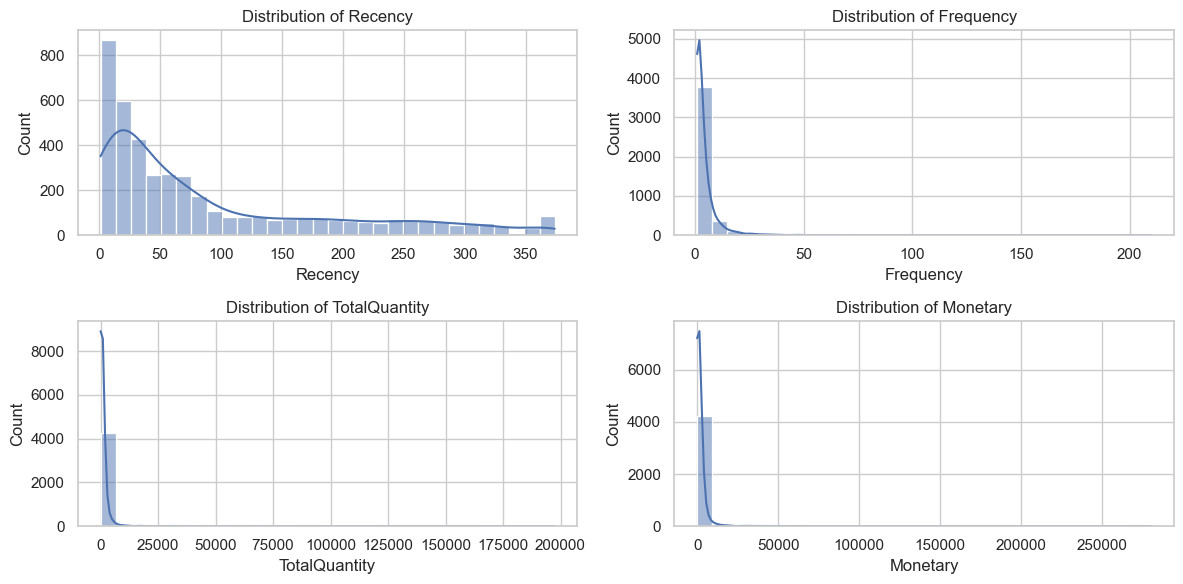

In [12]:
# Plot distributions
plt.figure(figsize=(12,6))

for i, feature in enumerate(['Recency', 'Frequency', 'TotalQuantity', 'Monetary']):
    plt.subplot(2, 2, i+1)
    sns.histplot(customers[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()


# Step 7: Standardize the Features

Machine learning models work better when features are on the same scale.  
We will apply **StandardScaler** to normalize the data before applying PCA and clustering.

This ensures that:
- Features with large scales (like Monetary) don't dominate others.
- PCA can properly capture variance.


In [13]:
from sklearn.preprocessing import StandardScaler

# Select features
features = ['Recency', 'Frequency', 'TotalQuantity', 'Monetary']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customers[features])


# Step 8: Apply PCA (Principal Component Analysis)

We'll use PCA to reduce our dataset to **2 dimensions**, making it easier to visualize.  
PCA will capture the key structure in the data with fewer components.

We'll also check how much variance is explained by the 2 components.


In [29]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA columns to customers DataFrame
customers['PCA1'] = X_pca[:, 0]
customers['PCA2'] = X_pca[:, 1]

# Explained variance
print("Explained variance by each component:", pca.explained_variance_ratio_)
print("Total explained variance:", np.sum(pca.explained_variance_ratio_))


Explained variance by each component: [0.60672824 0.24699159]
Total explained variance: 0.8537198292222212


# Step 9: Elbow Method for K-Means

K-means requires us to choose the number of clusters **K**.  
We will use the **Elbow Method** to find the optimal value by plotting WCSS (within-cluster sum of squares) for different K values.

We'll try K from 1 to 10.



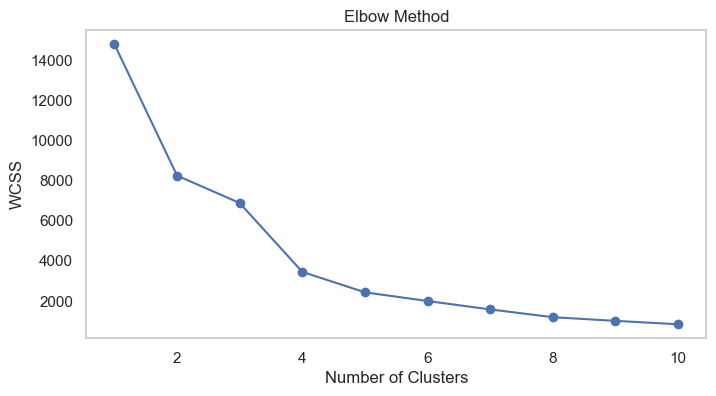

In [20]:
wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot WCSS vs number of clusters
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()


# Step 10: Apply K-Means and Evaluate Clustering

Based on the Elbow plot, we'll choose **K=3** (as an example).  
We'll apply K-Means and evaluate it using the **Silhouette Score**, which measures how well each point fits into its cluster.


In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Apply K-means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
customers['Cluster'] = kmeans.fit_predict(X_pca)

# Evaluate using silhouette score
score = silhouette_score(X_pca, customers['Cluster'])
print(f'Silhouette Score: {score:.3f}')


Silhouette Score: 0.823


# Step 11: Visualize Customer Segments

We now visualize the customers in the 2D PCA space, colored by their cluster assignment.
This helps us understand how well-separated the clusters are.


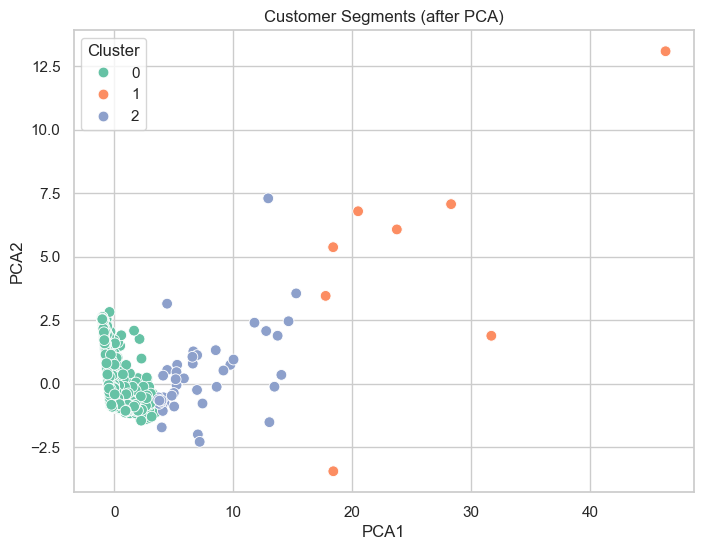

In [31]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=customers, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=60)
plt.title('Customer Segments (after PCA)')
plt.show()


# Step 12: Cluster Profiling

Now that we've clustered the customers, we want to understand the characteristics of each group.

We'll calculate the average values of key behavioral features for each cluster:
- Recency
- Frequency
- TotalQuantity
- Monetary

This will help us interpret the meaning of each segment and how they differ.


In [24]:
# Group by cluster and calculate mean of original features
cluster_profile = customers.groupby('Cluster')[['Recency', 'Frequency', 'TotalQuantity', 'Monetary']].mean()
cluster_profile = cluster_profile.round(2)
cluster_profile


,Recency,Frequency,TotalQuantity,Monetary
Cluster,,,,
0,93.48,3.75,809.72,1382.18
1,6.00,83.62,81725.12,165201.95
2,18.20,39.35,22662.09,35716.06


# Step 13: Visualize Cluster Profiles

We use bar plots to compare the average behavior of each customer group.  
This gives us a clearer picture of how segments differ in spending, activity, and engagement.


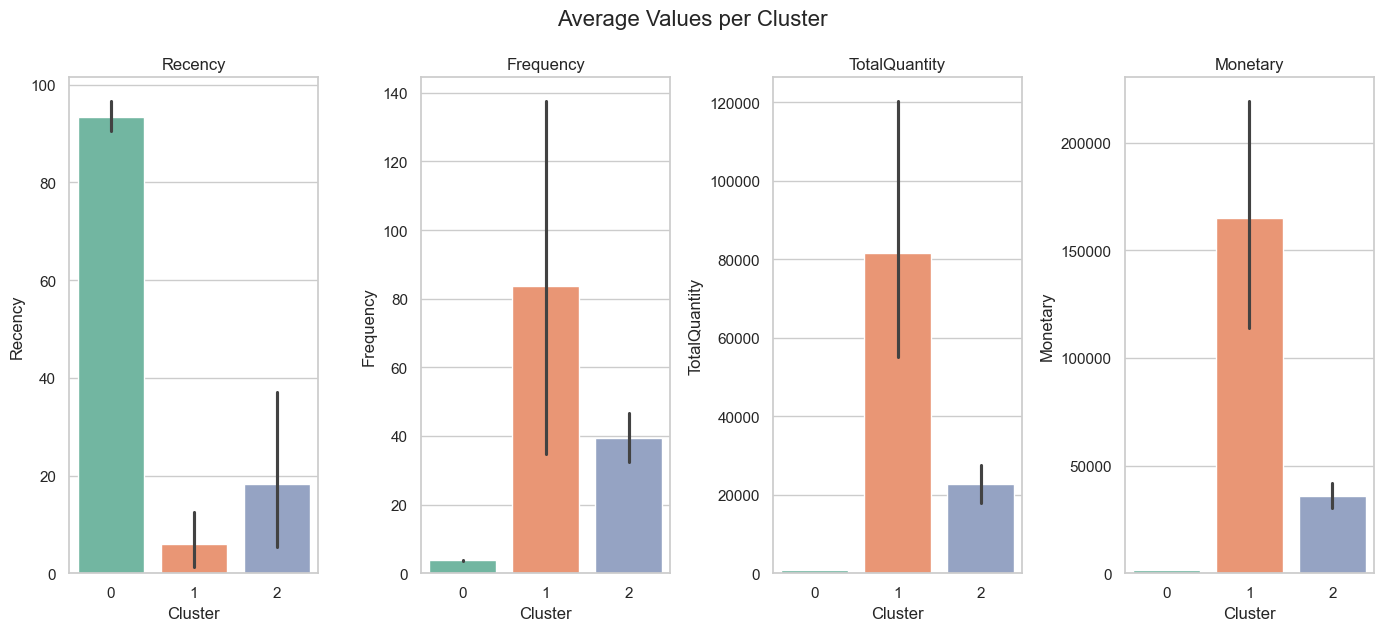

In [25]:
features = ['Recency', 'Frequency', 'TotalQuantity', 'Monetary']
plt.figure(figsize=(14, 6))

for i, col in enumerate(features):
    plt.subplot(1, 4, i+1)
    sns.barplot(data=customers, x='Cluster', y=col, palette='Set2')
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Average Values per Cluster", fontsize=16, y=1.05)
plt.show()


# Step 14: Final Insights and Recommendations

Based on the cluster profiles, we can now interpret the behavior of each group:

### 🔹 Cluster 0 – Inactive / Lapsed Customers
- **High Recency** → They haven't bought anything in a long time
- **Low Frequency & Monetary** → They barely engage or spend

**Strategy**:
- Reactivation campaigns
- Special offers to win them back
- Highlight what's new or improved

---

### 🔹 Cluster 1 – Loyal High-Spenders
- **Low Recency** → They recently purchased
- **High Frequency & Monetary** → Very engaged, valuable customers

**Strategy**:
- Loyalty programs
- Personalized deals
- Exclusive early access

---

### 🔹 Cluster 2 – Mid-Tier Customers
- **Medium Recency/Frequency**
- Some engagement, moderate value

**Strategy**:
- Encourage with bundle offers or limited-time discounts
- Cross-sell products based on purchase history

